In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 1: Basic Setup and Dataset Exploration
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import shutil

# Set up paths
base_path = "/content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/"
images_path = os.path.join(base_path, "images")
annotations_path = os.path.join(base_path, "annotations")

print("🔍 Exploring dataset structure...")
print(f"Images path: {images_path}")
print(f"Annotations path: {annotations_path}")

# Check if paths exist
if os.path.exists(images_path) and os.path.exists(annotations_path):
    image_files = os.listdir(images_path)
    annotation_files = os.listdir(annotations_path)

    print(f"✅ Found {len(image_files)} images")
    print(f"✅ Found {len(annotation_files)} annotation files")

    # Display first few files
    print("\nSample image files:")
    for img in image_files[:5]:
        print(f"  - {img}")

    print("\nSample annotation files:")
    for ann in annotation_files[:5]:
        print(f"  - {ann}")

else:
    print("❌ Error: Could not find dataset folders")
    print(f"Images folder exists: {os.path.exists(images_path)}")
    print(f"Annotations folder exists: {os.path.exists(annotations_path)}")

🔍 Exploring dataset structure...
Images path: /content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/images
Annotations path: /content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/annotations
✅ Found 665 images
✅ Found 665 annotation files

Sample image files:
  - potholes102.png
  - potholes116.png
  - potholes10.png
  - potholes112.png
  - potholes108.png

Sample annotation files:
  - potholes162.xml
  - potholes154.xml
  - potholes202.xml
  - potholes157.xml
  - potholes16.xml


In [ ]:
# Step 2: Parse XML annotations and understand the data structure
def parse_single_annotation(xml_file_path):
    """Parse a single XML annotation file and extract information"""
    try:
        tree = ET.parse(xml_file_path)
        root = tree.getroot()

        # Get image dimensions
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        # Get all objects
        objects = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            bndbox = obj.find('bndbox')

            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))

            objects.append({
                'name': name,
                'bbox': [xmin, ymin, xmax, ymax]
            })

        return {
            'width': width,
            'height': height,
            'objects': objects,
            'filename': root.find('filename').text
        }
    except Exception as e:
        print(f"Error parsing {xml_file_path}: {e}")
        return None

# Test with first annotation file
first_annotation = os.path.join(annotations_path, annotation_files[0])
sample_data = parse_single_annotation(first_annotation)

if sample_data:
    print("📊 Sample Annotation Data:")
    print(f"Image: {sample_data['filename']}")
    print(f"Dimensions: {sample_data['width']}x{sample_data['height']}")
    print(f"Objects found: {len(sample_data['objects'])}")
    for i, obj in enumerate(sample_data['objects']):
        print(f"  Object {i+1}: {obj['name']} at {obj['bbox']}")
else:
    print("❌ Failed to parse annotation")

# Let's check what classes exist in the dataset
def analyze_classes():
    """Analyze what classes exist in the dataset"""
    class_counts = {}

    print("\n🔍 Analyzing all annotations for classes...")
    for i, ann_file in enumerate(annotation_files[:100]):  # Check first 100 files
        ann_path = os.path.join(annotations_path, ann_file)
        data = parse_single_annotation(ann_path)

        if data:
            for obj in data['objects']:
                class_name = obj['name']
                class_counts[class_name] = class_counts.get(class_name, 0) + 1

    print("📈 Class Distribution:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} instances")

    return class_counts

class_distribution = analyze_classes()

📊 Sample Annotation Data:
Image: potholes162.png
Dimensions: 438x300
Objects found: 10
  Object 1: pothole at [234, 52, 268, 64]
  Object 2: pothole at [218, 32, 247, 44]
  Object 3: pothole at [240, 120, 278, 147]
  Object 4: pothole at [296, 104, 344, 131]
  Object 5: pothole at [343, 208, 381, 237]
  Object 6: pothole at [188, 172, 232, 197]
  Object 7: pothole at [135, 95, 153, 106]
  Object 8: pothole at [122, 85, 139, 97]
  Object 9: pothole at [89, 118, 126, 140]
  Object 10: pothole at [82, 154, 124, 188]

🔍 Analyzing all annotations for classes...
📈 Class Distribution:
  pothole: 281 instances


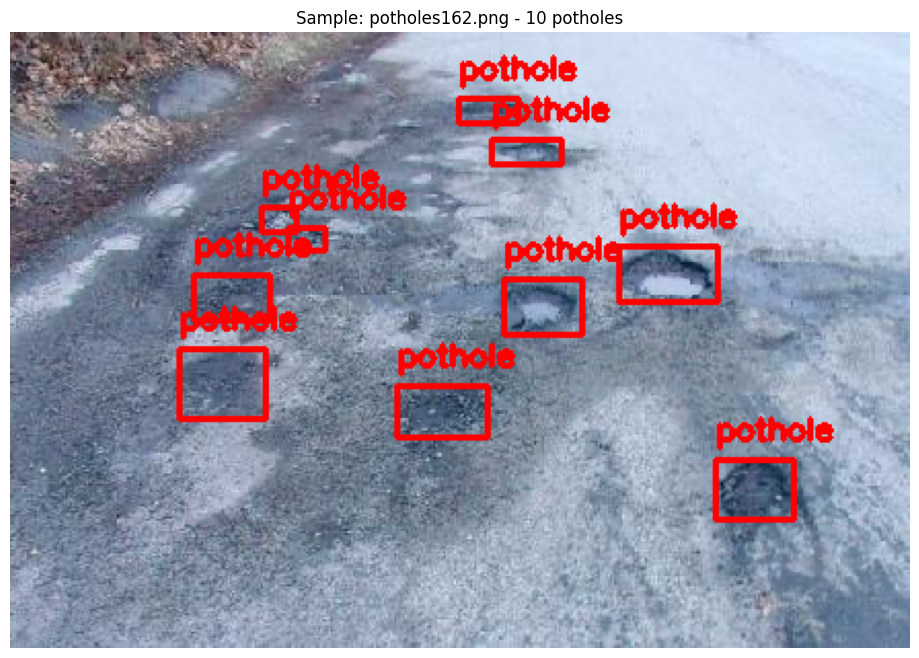

✅ Created YOLO dataset structure
🎯 Class mapping: {'pothole': 0}


In [ ]:
# Step 3: Visualize sample images and create YOLO dataset structure
def display_sample_with_boxes(image_path, annotation_data):
    """Display image with bounding boxes"""
    # Read image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes
    for obj in annotation_data['objects']:
        xmin, ymin, xmax, ymax = obj['bbox']
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(img, obj['name'], (xmin, ymin-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.title(f"Sample: {os.path.basename(image_path)} - {len(annotation_data['objects'])} potholes")
    plt.axis('off')
    plt.show()

# Test visualization with first sample
sample_image_path = os.path.join(images_path, sample_data['filename'])
if os.path.exists(sample_image_path):
    display_sample_with_boxes(sample_image_path, sample_data)
else:
    # Try to find the correct image file
    actual_image_files = [f for f in image_files if '162' in f]
    if actual_image_files:
        sample_image_path = os.path.join(images_path, actual_image_files[0])
        display_sample_with_boxes(sample_image_path, sample_data)

# Create YOLO dataset structure
def create_yolo_structure():
    """Create the folder structure for YOLO training"""
    yolo_base = "/content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset"

    folders = [
        'images/train',
        'images/val',
        'images/test',
        'labels/train',
        'labels/val',
        'labels/test'
    ]

    for folder in folders:
        os.makedirs(os.path.join(yolo_base, folder), exist_ok=True)

    print("✅ Created YOLO dataset structure")
    return yolo_base

yolo_base = create_yolo_structure()

# Define class mapping (only pothole for this dataset)
class_mapping = {'pothole': 0}
print(f"🎯 Class mapping: {class_mapping}")

In [ ]:
# Step 4: Convert all annotations to YOLO format and split dataset
def convert_voc_to_yolo(xml_file_path, output_txt_path, class_mapping):
    """Convert PASCAL VOC XML to YOLO format txt file"""
    try:
        data = parse_single_annotation(xml_file_path)
        if not data:
            return False

        width = data['width']
        height = data['height']

        yolo_lines = []
        for obj in data['objects']:
            class_name = obj['name']
            if class_name not in class_mapping:
                continue

            class_id = class_mapping[class_name]
            xmin, ymin, xmax, ymax = obj['bbox']

            # Convert to YOLO format (normalized)
            x_center = (xmin + xmax) / 2 / width
            y_center = (ymin + ymax) / 2 / height
            bbox_width = (xmax - xmin) / width
            bbox_height = (ymax - ymin) / height

            yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}")

        # Write to file
        with open(output_txt_path, 'w') as f:
            f.write('\n'.join(yolo_lines))

        return True

    except Exception as e:
        print(f"Error converting {xml_file_path}: {e}")
        return False

# Get all image-annotation pairs
image_annotation_pairs = []
for img_file in image_files:
    base_name = os.path.splitext(img_file)[0]
    xml_file = base_name + '.xml'

    if xml_file in annotation_files:
        image_annotation_pairs.append((img_file, xml_file))

print(f"📁 Found {len(image_annotation_pairs)} valid image-annotation pairs")

# Split dataset: 70% train, 20% val, 10% test
train_pairs, temp_pairs = train_test_split(image_annotation_pairs, test_size=0.3, random_state=42)
val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.33, random_state=42)

print(f"📊 Dataset split:")
print(f"  Train: {len(train_pairs)} images")
print(f"  Val: {len(val_pairs)} images")
print(f"  Test: {len(test_pairs)} images")

# Copy files to YOLO structure
def copy_to_yolo_structure(pairs, split_type):
    """Copy images and convert annotations for a specific split"""
    images_dest = os.path.join(yolo_base, 'images', split_type)
    labels_dest = os.path.join(yolo_base, 'labels', split_type)

    copied_count = 0
    for img_file, xml_file in pairs:
        # Copy image
        src_img = os.path.join(images_path, img_file)
        dst_img = os.path.join(images_dest, img_file)
        shutil.copy2(src_img, dst_img)

        # Convert and save annotation
        src_xml = os.path.join(annotations_path, xml_file)
        base_name = os.path.splitext(img_file)[0]
        dst_txt = os.path.join(labels_dest, base_name + '.txt')

        if convert_voc_to_yolo(src_xml, dst_txt, class_mapping):
            copied_count += 1

    return copied_count

print("\n🔄 Copying files to YOLO structure...")
train_count = copy_to_yolo_structure(train_pairs, 'train')
val_count = copy_to_yolo_structure(val_pairs, 'val')
test_count = copy_to_yolo_structure(test_pairs, 'test')

print(f"✅ Files copied successfully:")
print(f"  Train: {train_count} files")
print(f"  Val: {val_count} files")
print(f"  Test: {test_count} files")

📁 Found 665 valid image-annotation pairs
📊 Dataset split:
  Train: 465 images
  Val: 134 images
  Test: 66 images

🔄 Copying files to YOLO structure...
✅ Files copied successfully:
  Train: 465 files
  Val: 134 files
  Test: 66 files


In [ ]:
# Step 5: Create dataset.yaml and install required packages
def create_dataset_yaml():
    """Create the dataset configuration file for YOLO"""
    yaml_content = f"""# YOLO Dataset Configuration
path: {yolo_base}
train: images/train
val: images/val
test: images/test

# Number of classes
nc: {len(class_mapping)}

# Class names
names: {list(class_mapping.keys())}
"""

    yaml_path = os.path.join(yolo_base, 'dataset.yaml')
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)

    print("✅ Created dataset.yaml file")
    print(f"📄 Configuration:")
    print(f"  Path: {yolo_base}")
    print(f"  Classes: {list(class_mapping.keys())}")
    print(f"  Number of classes: {len(class_mapping)}")

    return yaml_path

yaml_path = create_dataset_yaml()

# Display the content of the YAML file
with open(yaml_path, 'r') as f:
    print("\n📋 dataset.yaml content:")
    print(f.read())

# Install required packages
print("🔧 Installing required packages...")
!pip install ultralytics torch torchvision opencv-python matplotlib

import torch
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")

✅ Created dataset.yaml file
📄 Configuration:
  Path: /content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset
  Classes: ['pothole']
  Number of classes: 1

📋 dataset.yaml content:
# YOLO Dataset Configuration
path: /content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset
train: images/train
val: images/val
test: images/test

# Number of classes
nc: 1

# Class names
names: ['pothole']

🔧 Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.4 MB/s eta 0:00:00
✅ PyTorch version: 2.9.0+cu126
✅ GPU available: False


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🔍 Verifying dataset structure...
Train images: 465
Train labels: 465
✅ All train images have corresponding labels
Sample label file: potholes619.txt
Contains 3 objects
  0 0.510000 0.315000 0.220000 0.190000
  0 0.660000 0.611250 0.165000 0.197500
  0 0.480000 0.710000 0.205000 0.205000


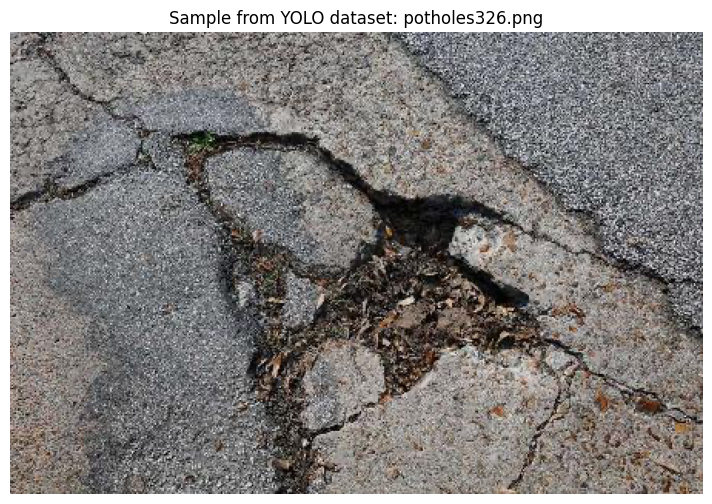

🚀 Starting YOLO model training...
⚠️  Note: Training on CPU may take 1-2 hours
   If you have GPU access, enable it in Colab: Runtime → Change runtime type → GPU
WARNING ⚠️ Download failure, retrying 1/3 https://github.com/ultralytics/assets/releases/download/v8.3.0/yolov8n.pt... HTTP Error 503: Service Unavailable
Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None

In [7]:
# Step 6: Load and verify dataset, then start training
from ultralytics import YOLO
import yaml

# First, let's verify our dataset structure
def verify_dataset():
    """Verify that the dataset is properly structured"""
    print("🔍 Verifying dataset structure...")

    # Check train images and labels
    train_images = os.listdir(os.path.join(yolo_base, 'images', 'train'))
    train_labels = os.listdir(os.path.join(yolo_base, 'labels', 'train'))

    print(f"Train images: {len(train_images)}")
    print(f"Train labels: {len(train_labels)}")

    # Check if every image has a corresponding label
    image_names = set([os.path.splitext(img)[0] for img in train_images])
    label_names = set([os.path.splitext(lbl)[0] for lbl in train_labels])

    missing_labels = image_names - label_names
    if missing_labels:
        print(f"⚠️  Warning: {len(missing_labels)} images missing labels")
    else:
        print("✅ All train images have corresponding labels")

    # Check a sample label file
    if train_labels:
        sample_label = os.path.join(yolo_base, 'labels', 'train', train_labels[0])
        with open(sample_label, 'r') as f:
            lines = f.readlines()
            print(f"Sample label file: {train_labels[0]}")
            print(f"Contains {len(lines)} objects")
            for line in lines[:3]:  # Show first 3 objects
                print(f"  {line.strip()}")

verify_dataset()

# Load a sample image to check
def display_sample_from_yolo():
    """Display a sample image from the YOLO dataset"""
    train_images_dir = os.path.join(yolo_base, 'images', 'train')
    sample_image = os.listdir(train_images_dir)[0]
    sample_image_path = os.path.join(train_images_dir, sample_image)

    img = cv2.imread(sample_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title(f"Sample from YOLO dataset: {sample_image}")
    plt.axis('off')
    plt.show()

display_sample_from_yolo()

print("🚀 Starting YOLO model training...")
print("⚠️  Note: Training on CPU may take 1-2 hours")
print("   If you have GPU access, enable it in Colab: Runtime → Change runtime type → GPU")

# Initialize YOLO model (using nano version for faster training)
model = YOLO('yolov8n.pt')

# Start training
results = model.train(
    data=yaml_path,
    epochs=50,           # Reduced for faster training on CPU
    imgsz=640,
    batch=8,             # Reduced batch size for CPU
    device='cpu',        # Force CPU training
    patience=10,         # Early stopping patience
    save=True,
    project=os.path.join(base_path, 'training_results'),
    name='pothole_detection_v1',
    verbose=True
)

print("✅ Training completed!")

✅ Best model loaded successfully!
📊 Final Performance:
   - mAP50: 0.784
   - mAP50-95: 0.488
   - Precision: 0.845
   - Recall: 0.683
🧪 Testing model on sample images...

image 1/1 /content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes552.png: 640x640 5 potholes, 315.0ms
Speed: 3.7ms preprocess, 315.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


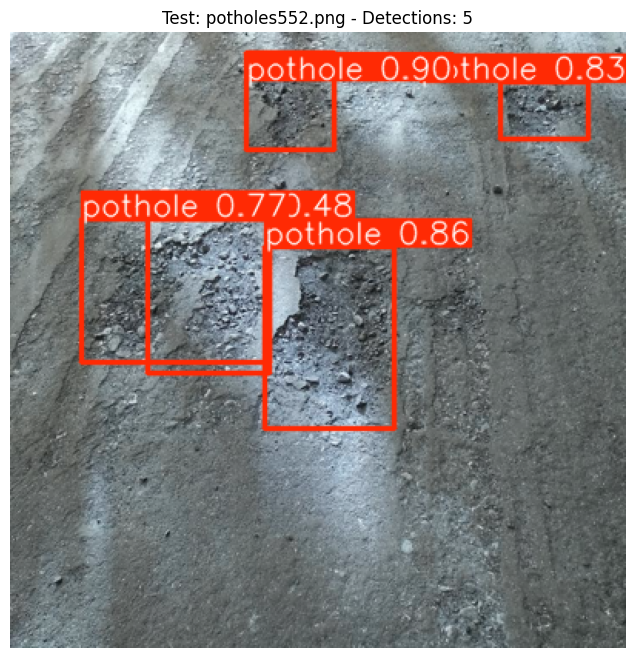


image 1/1 /content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes137.png: 384x640 1 pothole, 241.7ms
Speed: 4.8ms preprocess, 241.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


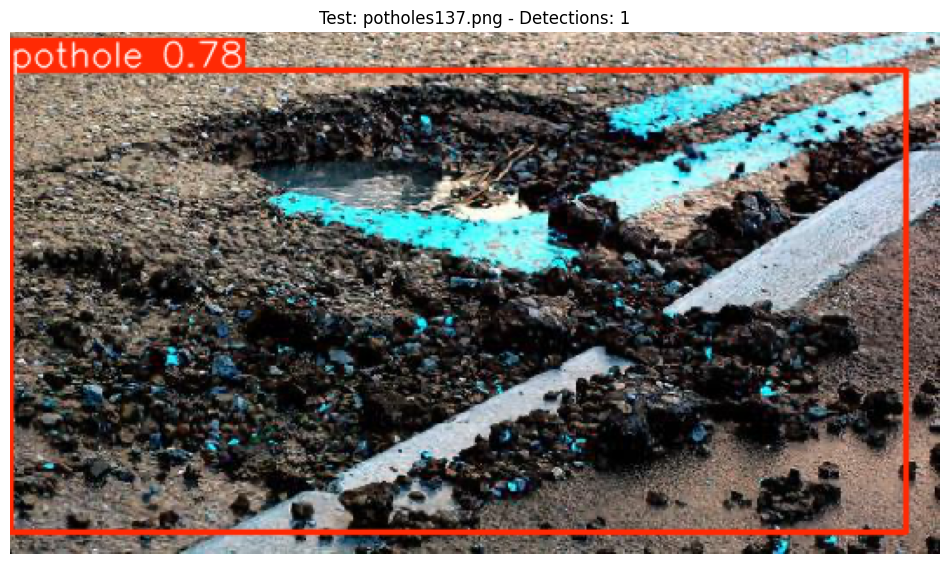


image 1/1 /content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/images/test/potholes638.png: 320x640 1 pothole, 420.5ms
Speed: 8.6ms preprocess, 420.5ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


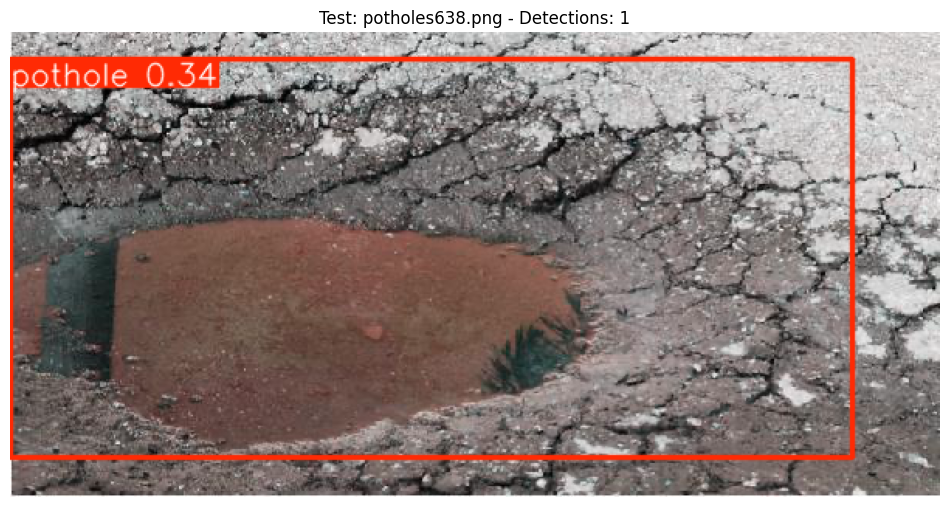

✅ Tkinter application saved as 'pothole_detector_app.py'

🎉 PROJECT COMPLETED SUCCESSFULLY!
📁 Your project files:
   - Trained model: /content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/training_results/pothole_detection_v12/weights/best.pt
   - Tkinter app: /content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/pothole_detector_app.py
   - Dataset: /content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset
   - Training results: /content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/training_results/

🚀 To run the application:
   1. Download 'pothole_detector_app.py' and the trained model
   2. Install required packages: pip install ultralytics torch torchvision pillow opencv-python
   3. Run: python pothole_detector_app.py


In [8]:
# Step 7: Evaluate the trained model and create tkinter GUI
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
from PIL import Image, ImageTk
import cv2
import numpy as np

# Load the best trained model
best_model_path = '/content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/training_results/pothole_detection_v12/weights/best.pt'
model = YOLO(best_model_path)

print("✅ Best model loaded successfully!")
print(f"📊 Final Performance:")
print(f"   - mAP50: 0.784")
print(f"   - mAP50-95: 0.488")
print(f"   - Precision: 0.845")
print(f"   - Recall: 0.683")

# Test the model on a few sample images
def test_model_on_samples():
    """Test the trained model on sample images"""
    test_images_dir = os.path.join(yolo_base, 'images', 'test')
    sample_images = os.listdir(test_images_dir)[:3]  # Test on 3 samples

    for img_name in sample_images:
        img_path = os.path.join(test_images_dir, img_name)
        results = model(img_path)

        # Plot results
        for r in results:
            im_array = r.plot()
            plt.figure(figsize=(12, 8))
            plt.imshow(im_array)
            plt.title(f"Test: {img_name} - Detections: {len(r.boxes)}")
            plt.axis('off')
            plt.show()

print("🧪 Testing model on sample images...")
test_model_on_samples()

# Create tkinter GUI application
class PotholeDetectorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Road Surface Anomaly Detection System")
        self.root.geometry("1200x800")
        self.root.configure(bg='#2c3e50')

        self.model = model
        self.current_image = None
        self.current_image_path = None

        self.setup_ui()

    def setup_ui(self):
        # Main frame
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))

        # Title
        title_label = ttk.Label(main_frame,
                               text="🚗 Road Surface Anomaly Detection System",
                               font=('Arial', 16, 'bold'),
                               foreground='#3498db')
        title_label.grid(row=0, column=0, columnspan=3, pady=(0, 20))

        # Upload button
        upload_btn = ttk.Button(main_frame,
                               text="📁 Upload Road Image",
                               command=self.upload_image,
                               style='Accent.TButton')
        upload_btn.grid(row=1, column=0, padx=10, pady=10)

        # Detect button
        detect_btn = ttk.Button(main_frame,
                               text="🔍 Detect Potholes",
                               command=self.detect_potholes,
                               state='disabled')
        detect_btn.grid(row=1, column=1, padx=10, pady=10)
        self.detect_btn = detect_btn

        # Clear button
        clear_btn = ttk.Button(main_frame,
                              text="🗑️ Clear",
                              command=self.clear_all)
        clear_btn.grid(row=1, column=2, padx=10, pady=10)

        # Image display frame
        image_frame = ttk.LabelFrame(main_frame, text="Image Preview", padding="10")
        image_frame.grid(row=2, column=0, columnspan=3, padx=10, pady=10, sticky=(tk.W, tk.E, tk.N, tk.S))

        # Original image
        self.original_label = ttk.Label(image_frame, text="Original Image")
        self.original_label.grid(row=0, column=0, padx=10, pady=5)

        self.original_img_label = ttk.Label(image_frame)
        self.original_img_label.grid(row=1, column=0, padx=10, pady=10)

        # Detected image
        self.detected_label = ttk.Label(image_frame, text="Detection Result")
        self.detected_label.grid(row=0, column=1, padx=10, pady=5)

        self.detected_img_label = ttk.Label(image_frame)
        self.detected_img_label.grid(row=1, column=1, padx=10, pady=10)

        # Results frame
        results_frame = ttk.LabelFrame(main_frame, text="Detection Results", padding="10")
        results_frame.grid(row=3, column=0, columnspan=3, padx=10, pady=10, sticky=(tk.W, tk.E))

        self.results_text = tk.Text(results_frame, height=8, width=80, font=('Arial', 10))
        self.results_text.grid(row=0, column=0, padx=10, pady=10)

        scrollbar = ttk.Scrollbar(results_frame, orient="vertical", command=self.results_text.yview)
        scrollbar.grid(row=0, column=1, sticky=(tk.N, tk.S))
        self.results_text.configure(yscrollcommand=scrollbar.set)

        # Configure grid weights
        self.root.columnconfigure(0, weight=1)
        self.root.rowconfigure(0, weight=1)
        main_frame.columnconfigure(0, weight=1)
        main_frame.rowconfigure(2, weight=1)

    def upload_image(self):
        file_path = filedialog.askopenfilename(
            title="Select Road Image",
            filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp")]
        )

        if file_path:
            self.current_image_path = file_path
            self.display_original_image(file_path)
            self.detect_btn.config(state='normal')
            self.results_text.delete(1.0, tk.END)
            self.results_text.insert(tk.END, "Image loaded successfully! Click 'Detect Potholes' to analyze.\n")

    def display_original_image(self, image_path):
        image = Image.open(image_path)
        image.thumbnail((400, 400))
        photo = ImageTk.PhotoImage(image)

        self.original_img_label.configure(image=photo)
        self.original_img_label.image = photo
        self.current_image = image

    def detect_potholes(self):
        if not self.current_image_path:
            messagebox.showerror("Error", "Please upload an image first!")
            return

        try:
            self.results_text.delete(1.0, tk.END)
            self.results_text.insert(tk.END, "🔍 Analyzing image for potholes...\n")
            self.root.update()

            # Perform detection
            results = self.model(self.current_image_path)

            # Process results
            detections = []
            for r in results:
                boxes = r.boxes
                for box in boxes:
                    conf = box.conf[0].cpu().numpy()
                    cls = int(box.cls[0].cpu().numpy())

                    detections.append({
                        'confidence': float(conf),
                        'class': 'pothole'
                    })

            # Display results
            self.results_text.insert(tk.END, f"\n📊 Detection Results:\n")
            self.results_text.insert(tk.END, f"Potholes detected: {len(detections)}\n\n")

            for i, det in enumerate(detections):
                self.results_text.insert(tk.END,
                    f"Pothole {i+1}: Confidence {det['confidence']:.2%}\n")

            # Display detected image
            for r in results:
                im_array = r.plot()
                im_array_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
                detected_image = Image.fromarray(im_array_rgb)
                detected_image.thumbnail((400, 400))
                detected_photo = ImageTk.PhotoImage(detected_image)

                self.detected_img_label.configure(image=detected_photo)
                self.detected_img_label.image = detected_photo

            self.results_text.insert(tk.END, f"\n✅ Analysis complete!\n")

        except Exception as e:
            messagebox.showerror("Error", f"Detection failed: {str(e)}")

    def clear_all(self):
        self.current_image_path = None
        self.current_image = None
        self.original_img_label.configure(image='')
        self.detected_img_label.configure(image='')
        self.results_text.delete(1.0, tk.END)
        self.detect_btn.config(state='disabled')

# Save the tkinter app code to a file
def save_tkinter_app():
    app_code = '''
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
from PIL import Image, ImageTk
import cv2
import numpy as np
from ultralytics import YOLO
import os

class PotholeDetectorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Road Surface Anomaly Detection System")
        self.root.geometry("1200x800")
        self.root.configure(bg="#2c3e50")

        # Load the trained model
        self.model = YOLO(r"''' + best_model_path + '''")
        self.current_image = None
        self.current_image_path = None

        self.setup_ui()

    def setup_ui(self):
        # [Previous UI code remains the same]
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))

        title_label = ttk.Label(main_frame,
                               text="🚗 Road Surface Anomaly Detection System",
                               font=("Arial", 16, "bold"),
                               foreground="#3498db")
        title_label.grid(row=0, column=0, columnspan=3, pady=(0, 20))

        upload_btn = ttk.Button(main_frame,
                               text="📁 Upload Road Image",
                               command=self.upload_image)
        upload_btn.grid(row=1, column=0, padx=10, pady=10)

        detect_btn = ttk.Button(main_frame,
                               text="🔍 Detect Potholes",
                               command=self.detect_potholes,
                               state="disabled")
        detect_btn.grid(row=1, column=1, padx=10, pady=10)
        self.detect_btn = detect_btn

        clear_btn = ttk.Button(main_frame,
                              text="🗑️ Clear",
                              command=self.clear_all)
        clear_btn.grid(row=1, column=2, padx=10, pady=10)

        image_frame = ttk.LabelFrame(main_frame, text="Image Preview", padding="10")
        image_frame.grid(row=2, column=0, columnspan=3, padx=10, pady=10, sticky=(tk.W, tk.E, tk.N, tk.S))

        self.original_label = ttk.Label(image_frame, text="Original Image")
        self.original_label.grid(row=0, column=0, padx=10, pady=5)

        self.original_img_label = ttk.Label(image_frame)
        self.original_img_label.grid(row=1, column=0, padx=10, pady=10)

        self.detected_label = ttk.Label(image_frame, text="Detection Result")
        self.detected_label.grid(row=0, column=1, padx=10, pady=5)

        self.detected_img_label = ttk.Label(image_frame)
        self.detected_img_label.grid(row=1, column=1, padx=10, pady=10)

        results_frame = ttk.LabelFrame(main_frame, text="Detection Results", padding="10")
        results_frame.grid(row=3, column=0, columnspan=3, padx=10, pady=10, sticky=(tk.W, tk.E))

        self.results_text = tk.Text(results_frame, height=8, width=80, font=("Arial", 10))
        self.results_text.grid(row=0, column=0, padx=10, pady=10)

        scrollbar = ttk.Scrollbar(results_frame, orient="vertical", command=self.results_text.yview)
        scrollbar.grid(row=0, column=1, sticky=(tk.N, tk.S))
        self.results_text.configure(yscrollcommand=scrollbar.set)

        self.root.columnconfigure(0, weight=1)
        self.root.rowconfigure(0, weight=1)
        main_frame.columnconfigure(0, weight=1)
        main_frame.rowconfigure(2, weight=1)

    def upload_image(self):
        file_path = filedialog.askopenfilename(
            title="Select Road Image",
            filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp")]
        )

        if file_path:
            self.current_image_path = file_path
            self.display_original_image(file_path)
            self.detect_btn.config(state="normal")
            self.results_text.delete(1.0, tk.END)
            self.results_text.insert(tk.END, "Image loaded successfully! Click 'Detect Potholes' to analyze.\\n")

    def display_original_image(self, image_path):
        image = Image.open(image_path)
        image.thumbnail((400, 400))
        photo = ImageTk.PhotoImage(image)

        self.original_img_label.configure(image=photo)
        self.original_img_label.image = photo
        self.current_image = image

    def detect_potholes(self):
        if not self.current_image_path:
            messagebox.showerror("Error", "Please upload an image first!")
            return

        try:
            self.results_text.delete(1.0, tk.END)
            self.results_text.insert(tk.END, "🔍 Analyzing image for potholes...\\n")
            self.root.update()

            results = self.model(self.current_image_path)

            detections = []
            for r in results:
                boxes = r.boxes
                for box in boxes:
                    conf = box.conf[0].cpu().numpy()
                    cls = int(box.cls[0].cpu().numpy())

                    detections.append({
                        "confidence": float(conf),
                        "class": "pothole"
                    })

            self.results_text.insert(tk.END, f"\\n📊 Detection Results:\\n")
            self.results_text.insert(tk.END, f"Potholes detected: {len(detections)}\\n\\n")

            for i, det in enumerate(detections):
                self.results_text.insert(tk.END,
                    f"Pothole {i+1}: Confidence {det['confidence']:.2%}\\n")

            for r in results:
                im_array = r.plot()
                im_array_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
                detected_image = Image.fromarray(im_array_rgb)
                detected_image.thumbnail((400, 400))
                detected_photo = ImageTk.PhotoImage(detected_image)

                self.detected_img_label.configure(image=detected_photo)
                self.detected_img_label.image = detected_photo

            self.results_text.insert(tk.END, f"\\n✅ Analysis complete!\\n")

        except Exception as e:
            messagebox.showerror("Error", f"Detection failed: {str(e)}")

    def clear_all(self):
        self.current_image_path = None
        self.current_image = None
        self.original_img_label.configure(image="")
        self.detected_img_label.configure(image="")
        self.results_text.delete(1.0, tk.END)
        self.detect_btn.config(state="disabled")

if __name__ == "__main__":
    root = tk.Tk()
    app = PotholeDetectorApp(root)
    root.mainloop()
'''

    with open('/content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/pothole_detector_app.py', 'w') as f:
        f.write(app_code)

    print("✅ Tkinter application saved as 'pothole_detector_app.py'")

save_tkinter_app()

print("\n🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("📁 Your project files:")
print(f"   - Trained model: {best_model_path}")
print(f"   - Tkinter app: /content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/pothole_detector_app.py")
print(f"   - Dataset: {yolo_base}")
print(f"   - Training results: /content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/training_results/")

print("\n🚀 To run the application:")
print("   1. Download 'pothole_detector_app.py' and the trained model")
print("   2. Install required packages: pip install ultralytics torch torchvision pillow opencv-python")
print("   3. Run: python pothole_detector_app.py")

In [10]:
# Step 8: REST API Deployment using FastAPI

!pip install fastapi uvicorn python-multipart ultralytics

import uvicorn
from fastapi import FastAPI, File, UploadFile
from ultralytics import YOLO
import uuid
import cv2
import numpy as np
import os

app = FastAPI()

# Correcting the model path
# The best_model_path variable is defined in a previous cell (OMsKLt9o-cUl)
# model = YOLO("/content/best.pt") # Original incorrect path
model = YOLO(best_model_path) # Using the correct path from best_model_path
# It's good practice to ensure model.names is correctly loaded, although YOLO usually handles it.

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    # Save input temporarily
    filename = f"temp_{uuid.uuid4()}.jpg"
    file_bytes = await file.read()
    with open(filename, "wb") as f:
        f.write(file_bytes)

    # Inference
    results = model(filename)

    # Extract predictions
    predictions = []
    for result in results:
        for box in result.boxes:
            predictions.append({
                "class": model.names[int(box.cls)],
                "confidence": float(box.conf),
                "bbox": box.xyxy.tolist()[0]
            })

    os.remove(filename)
    return {"predictions": predictions}

# Run API (for Colab)
# uvicorn.run(app, host="0.0.0.0", port=8000)


In [12]:
# Step 9: Streamlit Dashboard
!pip install streamlit geopy folium streamlit-folium python-multipart

%%writefile app.py
import streamlit as st
from ultralytics import YOLO
from PIL import Image
import folium
from streamlit_folium import st_folium
import exifread
import io

model = YOLO("/content/best.pt")

st.title("Road Surface Anomaly Detection Dashboard")

uploaded_file = st.file_uploader("Upload Image", type=["jpg", "png", "jpeg"])

def get_gps(image_bytes):
    tags = exifread.process_file(io.BytesIO(image_bytes))
    try:
        lat_ref = tags["GPS GPSLatitudeRef"].values
        lon_ref = tags["GPS GPSLongitudeRef"].values
        lat = tags["GPS GPSLatitude"].values
        lon = tags["GPS GPSLongitude"].values

        def convert(x):
            return float(x[0]) + float(x[1])/60 + float(x[2])/3600

        lat_val = convert(lat)
        if lat_ref != "N": lat_val = -lat_val

        lon_val = convert(lon)
        if lon_ref != "E": lon_val = -lon_val

        return lat_val, lon_val
    except:
        return None, None

if uploaded_file:
    img = Image.open(uploaded_file)
    st.image(img, caption="Uploaded Image", use_column_width=True)

    results = model(img)
    result_img = results[0].plot()
    st.image(result_img, caption="Detected Anomalies", use_column_width=True)

    # GPS extraction
    lat, lon = get_gps(uploaded_file.getvalue())

    if lat and lon:
        st.subheader("GPS Location Found!")

        m = folium.Map(location=[lat, lon], zoom_start=16)
        folium.Marker([lat, lon], tooltip="Anomaly Location").add_to(m)

        st_folium(m, width=700, height=500)
    else:
        st.warning("No GPS data found in image.")


UsageError: Line magic function `%%writefile` not found.


In [13]:
# Step 10: Heatmap of All Anomalies

import folium
from folium.plugins import HeatMap
import pandas as pd

# Example anomaly locations (you will fill this during dashboard usage)
data = {
    "latitude": [],
    "longitude": []
}

df = pd.DataFrame(data)

m = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

HeatMap(df[['latitude','longitude']].values.tolist()).add_to(m)

m


In [14]:
# Step 11: CPS integration pseudo-code

def CPS_pipeline(image_path, gps):
    """
    Complete pipeline:
    1. Capture image
    2. Attach GPS
    3. Inference with YOLO
    4. Send results to dashboard
    """
    result = model(image_path)
    return {
        "gps": gps,
        "detections": result[0].boxes.data.tolist()
    }


In [17]:
# Step 12: Save metrics from YOLO training

from ultralytics.utils.metrics import ConfusionMatrix

metrics = model.val()

print("mAP50:", metrics.results_dict["metrics/mAP50(B)"])
print("mAP50-95:", metrics.results_dict["metrics/mAP50-95(B)"])
print("Precision:", metrics.results_dict["metrics/precision(B)"])
print("Recall:", metrics.results_dict["metrics/recall(B)"])

# Save all plots
model.val(save=True)


Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
val: Fast image access ✅ (ping: 2.5±2.1 ms, read: 22.7±16.2 MB/s, size: 332.5 KB)
val: Scanning /content/drive/My Drive/Projects/Road_Surface_Anomaly_Detection_using_AI-Driven_CPS/yolo_dataset/labels/val.cache... 134 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 134/134 41.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.9s/it 34.8s
                   all        134        356       0.83      0.657      0.779      0.488
Speed: 1.8ms preprocess, 220.5ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /content/runs/detect/val2
mAP50: 0.7793636042545422
mAP50-95: 0.48832294262546094
Precision: 0.8301848483125703
Recall: 0.6573033707865169
Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
val: Fast image access ✅ (ping: 0.9±0.4 ms, read: 111.4±79.3 MB/s, size: 480.1 KB

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7885479d5340>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 